In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.nn.functional import normalize

In [65]:
#  -- Read in PEMS Traffic Dataset -- 

df = pd.read_csv('pems_data.csv')

df = df.drop("Timestep", axis=1)
df = df.drop("sensor", axis=1)

In [66]:
#  -- Split into array of 51 thousand time steps, accounting for fact there's 325 sensors at each time step -- 

num_timesteps = df.shape[0]/325
arr = df.to_numpy()
timeseries = np.asarray(np.array_split(arr, num_timesteps)) # this is a 51k long timeseries

In [67]:
# Flatten timeseries for later analysis against LSTM results

timeseries = timeseries.reshape(timeseries.shape[0], -1)

In [68]:
# -- Train-Test split --

TRAIN_PERCENT = .67

train_size = int(len(timeseries) * TRAIN_PERCENT)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [69]:

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset by creating "lookbacK" window
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X, dtype=torch.double), torch.tensor(y, dtype=torch.double)

In [70]:
# -- Normalize train and test datasets for better LSTM performance --

lookback = 4


X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
X_train = normalize(X_train, p=1.0, dim=2)
y_train = normalize(y_train, p=1.0, dim=2)
X_test = normalize(X_test, p=1.0, dim=2)
y_test = normalize(y_test, p=1.0, dim=2)

In [71]:
# -- Flatten 4D Vectors into 3D vectors by taking (325,2) sensor data and turning it into (625,1)
# Necessary for LSTM input 

X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1], -1).float()
y_train_flat = y_train.reshape(y_train.shape[0], y_train.shape[1], -1).float()
X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1], -1).float()
y_test_flat = y_test.reshape(y_test.shape[0], y_test.shape[1], -1).float()

In [72]:
# -- Define LSTM Layer Architecture -- 

class TrafficNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        """
        
        Intialize NN
        Parameter Notes:
            hidden_size = 50
            num_layers = 2
            input_size = 2
            batch_size = 325
        """
        
        
        self.lstm = nn.LSTM(input_size=650, hidden_size=50, num_layers=2, batch_first=True)
        self.linear = nn.Linear(50, 650)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [73]:
# -- Define LSTM Layer Architecture -- 

class NonStackedTrafficNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        """
        
        Intialize NN
        Parameter Notes:
            hidden_size = 64
            num_layers = 1
            input_size = 2
            batch_size = 325
            rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, batch_first=False)
        """
        
        
        self.lstm = nn.LSTM(input_size=650, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 650)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [74]:
# -- Non-stacked LSTM -- 

n_epochs = 30

model_one = NonStackedTrafficNetwork()
optimizer = optim.Adam(model_one.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train_flat, y_train_flat), shuffle=True, batch_size=8)


non_stacked_train_losses = []
non_stacked_test_losses = []

for epoch in range(n_epochs):
    model_one.train()
    for X_batch, y_batch in loader:
        y_pred = model_one(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        
        if epoch != n_epochs - 1: 
            loss.backward(retain_graph=True) #necessary to avoid recompute exception
        else: 
            loss.backward()
            
        optimizer.step()
    #Validation
    # if epoch % 100 != 0:
    #     continue
    model_one.eval()
    with torch.no_grad():
        y_pred = model_one(X_train_flat)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train_flat))
        y_pred = model_one(X_test_flat)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test_flat))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    non_stacked_train_losses.append(train_rmse)
    non_stacked_test_losses.append(test_rmse)



Epoch 0: train RMSE 0.0003, test RMSE 0.0004
Epoch 1: train RMSE 0.0003, test RMSE 0.0003
Epoch 2: train RMSE 0.0003, test RMSE 0.0003
Epoch 3: train RMSE 0.0003, test RMSE 0.0003
Epoch 4: train RMSE 0.0003, test RMSE 0.0003
Epoch 5: train RMSE 0.0002, test RMSE 0.0003
Epoch 6: train RMSE 0.0002, test RMSE 0.0003
Epoch 7: train RMSE 0.0003, test RMSE 0.0003
Epoch 8: train RMSE 0.0003, test RMSE 0.0003
Epoch 9: train RMSE 0.0002, test RMSE 0.0002
Epoch 10: train RMSE 0.0002, test RMSE 0.0002
Epoch 11: train RMSE 0.0002, test RMSE 0.0002
Epoch 12: train RMSE 0.0002, test RMSE 0.0002
Epoch 13: train RMSE 0.0002, test RMSE 0.0002
Epoch 14: train RMSE 0.0002, test RMSE 0.0002
Epoch 15: train RMSE 0.0002, test RMSE 0.0002
Epoch 16: train RMSE 0.0002, test RMSE 0.0002
Epoch 17: train RMSE 0.0002, test RMSE 0.0002
Epoch 18: train RMSE 0.0002, test RMSE 0.0002
Epoch 19: train RMSE 0.0002, test RMSE 0.0002
Epoch 20: train RMSE 0.0002, test RMSE 0.0002
Epoch 21: train RMSE 0.0002, test RMSE 0.000

(52105, 1)
torch.Size([34906, 4, 650])


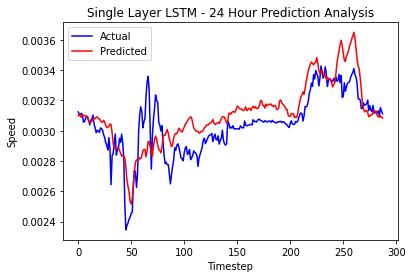

In [82]:
# -- Plotting -- 

ISOLATED_DATAPOINT = 512
ISOLATED_TIMESTEP = 1000
TIMESTEP_INTERVAL = 288



with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries[:,ISOLATED_DATAPOINT:ISOLATED_DATAPOINT+1]) * np.nan
    print(train_plot.shape)
    y_pred = model_one(X_train_flat)
    print(y_pred.shape)
    y_pred = y_pred[:, -1, ISOLATED_DATAPOINT:ISOLATED_DATAPOINT+1]
    
    train_plot[lookback:train_size] = model_one(X_train_flat)[:, -1, ISOLATED_DATAPOINT:ISOLATED_DATAPOINT+1]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries[:,ISOLATED_DATAPOINT:ISOLATED_DATAPOINT+1]) * np.nan
    test_plot[train_size+lookback:len(timeseries[:,ISOLATED_DATAPOINT:ISOLATED_DATAPOINT+1])] = model_one(X_test_flat)[:, -1, ISOLATED_DATAPOINT:ISOLATED_DATAPOINT+1]
# plot
plt.plot(timeseries[ISOLATED_TIMESTEP:ISOLATED_TIMESTEP+TIMESTEP_INTERVAL,ISOLATED_DATAPOINT:ISOLATED_DATAPOINT+1], c='b', label="Actual")
plt.plot(train_plot[ISOLATED_TIMESTEP:ISOLATED_TIMESTEP+TIMESTEP_INTERVAL,:], c='r', label="Predicted")
plt.plot(test_plot[ISOLATED_TIMESTEP:ISOLATED_TIMESTEP+TIMESTEP_INTERVAL, :], c='g')

plt.legend(loc="upper left")

plt.xlabel("Timestep")
plt.ylabel("Speed")

plt.title('Single Layer LSTM - 24 Hour Prediction Analysis')
plt.show()

In [76]:
# -- Training Loop --


model_two = TrafficNetwork()
optimizer = optim.Adam(model_two.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train_flat, y_train_flat), shuffle=True, batch_size=8)


train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model_two.train()
    for X_batch, y_batch in loader:
        y_pred = model_two(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        
        if epoch != n_epochs - 1: 
            loss.backward(retain_graph=True) #necessary to avoid recompute exception
        else: 
            loss.backward()
            
        optimizer.step()
    #Validation
    # if epoch % 100 != 0:
    #     continue
    model_two.eval()
    with torch.no_grad():
        y_pred = model_two(X_train_flat)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train_flat))
        y_pred = model_two(X_test_flat)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test_flat))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    train_losses.append(train_rmse)
    test_losses.append(test_rmse)



Epoch 0: train RMSE 0.0004, test RMSE 0.0004
Epoch 1: train RMSE 0.0003, test RMSE 0.0004
Epoch 2: train RMSE 0.0003, test RMSE 0.0003
Epoch 3: train RMSE 0.0003, test RMSE 0.0003
Epoch 4: train RMSE 0.0002, test RMSE 0.0003
Epoch 5: train RMSE 0.0003, test RMSE 0.0003
Epoch 6: train RMSE 0.0003, test RMSE 0.0003
Epoch 7: train RMSE 0.0002, test RMSE 0.0003
Epoch 8: train RMSE 0.0002, test RMSE 0.0002
Epoch 9: train RMSE 0.0002, test RMSE 0.0003
Epoch 10: train RMSE 0.0003, test RMSE 0.0003
Epoch 11: train RMSE 0.0002, test RMSE 0.0003
Epoch 12: train RMSE 0.0002, test RMSE 0.0003
Epoch 13: train RMSE 0.0002, test RMSE 0.0002
Epoch 14: train RMSE 0.0002, test RMSE 0.0002
Epoch 15: train RMSE 0.0002, test RMSE 0.0003
Epoch 16: train RMSE 0.0002, test RMSE 0.0003
Epoch 17: train RMSE 0.0002, test RMSE 0.0002
Epoch 18: train RMSE 0.0002, test RMSE 0.0002
Epoch 19: train RMSE 0.0002, test RMSE 0.0002
Epoch 20: train RMSE 0.0002, test RMSE 0.0002
Epoch 21: train RMSE 0.0002, test RMSE 0.000

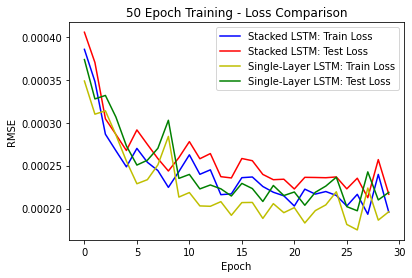

In [77]:
plt.plot(train_losses, c="b", label='Stacked LSTM: Train Loss')
plt.plot(test_losses, c="r", label='Stacked LSTM: Test Loss')
plt.plot(non_stacked_train_losses, c="y", label='Single-Layer LSTM: Train Loss')
plt.plot(non_stacked_test_losses, c="g", label='Single-Layer LSTM: Test Loss')

plt.legend(loc="upper right")

plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title('50 Epoch Training - Loss Comparison')
plt.show()

In [78]:
timeseries = torch.from_numpy(timeseries)


In [79]:
timeseries = normalize(timeseries, p=1.0)

(52105, 1)
torch.Size([34906, 4, 650])


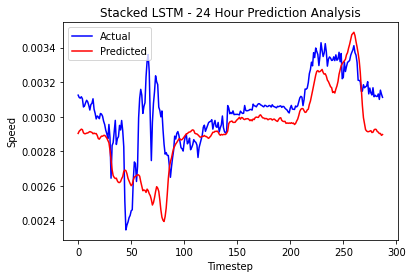

In [80]:
# -- Plotting -- 




with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries[:,ISOLATED_DATAPOINT:ISOLATED_DATAPOINT+1]) * np.nan
    print(train_plot.shape)
    y_pred = model_two(X_train_flat)
    print(y_pred.shape)
    y_pred = y_pred[:, -1, ISOLATED_DATAPOINT:ISOLATED_DATAPOINT+1]
    
    train_plot[lookback:train_size] = model_two(X_train_flat)[:, -1, ISOLATED_DATAPOINT:ISOLATED_DATAPOINT+1]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries[:,ISOLATED_DATAPOINT:ISOLATED_DATAPOINT+1]) * np.nan
    test_plot[train_size+lookback:len(timeseries[:,ISOLATED_DATAPOINT:ISOLATED_DATAPOINT+1])] = model_two(X_test_flat)[:, -1, ISOLATED_DATAPOINT:ISOLATED_DATAPOINT+1]
# plot
plt.plot(timeseries[ISOLATED_TIMESTEP:ISOLATED_TIMESTEP+TIMESTEP_INTERVAL,ISOLATED_DATAPOINT:ISOLATED_DATAPOINT+1], c='b', label="Actual")
plt.plot(train_plot[ISOLATED_TIMESTEP:ISOLATED_TIMESTEP+TIMESTEP_INTERVAL,:], c='r', label="Predicted")
plt.plot(test_plot[ISOLATED_TIMESTEP:ISOLATED_TIMESTEP+TIMESTEP_INTERVAL, :], c='g')

plt.legend(loc="upper left")

plt.xlabel("Timestep")
plt.ylabel("Speed")

plt.title('Stacked LSTM - 24 Hour Prediction Analysis')
plt.show()

In [81]:
# # fucking with shape
# with torch.no_grad():
#     # shift train predictions for plotting
#     train_plot = np.ones_like(timeseries) * np.nan
#     print(train_plot.shape)
#     y_pred = model(X_train_flat)
#     print(y_pred.shape)
#     y_pred = y_pred[:, -1, :]
    
#     train_plot[lookback:train_size] = model(X_train_flat)[:, -1, :]
#     # shift test predictions for plotting
#     test_plot = np.ones_like(timeseries) * np.nan
#     test_plot[train_size+lookback:len(timeseries)] = model(X_test_flat)[:, -1, :]
# # plot
# #plt.plot(timeseries, c='y')
# plt.plot(train_plot, c='r')
# plt.plot(test_plot, c='g')
# plt.show()